# Evaluating Models
## 1. Introduction
In this notebook, we do a very basic evaluation of each model against a manually generated dataset.
We will compare:
- BinaryNet
- XNOR-NET
- ABCNet

## 2. Generating Data
### 2.1 Function
We will choose a quadratic function:
$$
  F(x)=ax^2+bx+c
$$
### 2.2 Parameters
We will set:
- $a=2$
- $b=3$
- $c=2$

### 2.3 Data
1. We will generate $n=20000$ samples $X_1,\dots,X_n$ from the uniform distribution $\mathcal{U}(-4,4)$
2. We will generate $n=20000$ samples $\epsilon_1,\dots,\epsilon_n$ from the normal distribution $\mathcal{N}(0,\sigma),$ with $\sigma=0.1$
3. We will calculate $y_1,\dots,y_n$ as:
    $$
    y_i=aX_i^2+bX_i+c+\epsilon_i
    $$

In [1]:
import tensorflow as tf
import larq as lq
import numpy as np
from binaryflow import quantizers,layers
from sklearn.model_selection import train_test_split
from binaryflow.layers.XnorNet import *
from binaryflow.layers.ABCNet import *
from binaryflow.layers.BinaryNet import *
from binaryflow.block.BiRealNet import *


a=2
b=3
c=2
n=20000
std=0.1
np.random.seed(21)
tf.random.set_seed(27)
X=np.random.uniform(-4,4,[n,1])
err=np.random.normal(0,std,[n,1])
y=a*X**2+b*X+c+err

2022-08-04 00:21:22.755240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 00:21:22.783291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 00:21:22.783499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 00:21:22.784216: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## 3. Creating Models

In [ ]:
binarynet_args = dict(
    kernel_quantizer="ste_sign",
    input_quantizer="ste_sign",
    kernel_constraint="weight_clip",
    #kernel_params={"mu_initializer":tf.keras.initializers.RandomNormal(0,0.05)},
    use_bias=False
)

xnornet_args = dict(
    kernel_quantizer="ste_sign",
    input_quantizer="ste_sign",
    kernel_constraint="weight_clip",
    #kernel_params={"mu_initializer":tf.keras.initializers.RandomNormal(0,0.05)},
    use_bias=False
)

abcnet_args = dict(
    kernel_estimators=5,
    kernel_quantizers=quantizers.ShiftedSteSign,
    input_quantizers=quantizers.ShiftedSteSign,
    kernel_constraint="weight_clip",
    kernel_params={"mu_initializer":tf.keras.initializers.RandomNormal(0,0.05)},
    use_bias=False
)

X_train,X_test,y_train,y_test=train_test_split(X,y)


models={}
noisy_models={}
model_names=["BinaryNet","XNOR-NET","ABCNet"]
model_layers={"BinaryNet":lq.layers.QuantDense,"XNOR-NET":ScaledQuantDense,"ABCNet":ABCDense}

for name,kwargs in zip(model_names,[binarynet_args,xnornet_args,abcnet_args]):
    Dense=model_layers[name]
    layers=[tf.keras.layers.Dense(24),
            tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
            Dense(24,activation="relu", **kwargs),
            tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
            Dense(24,activation="relu", **kwargs),
            tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
            Dense(1, **kwargs)]
    models[name]=tf.keras.models.Sequential(layers)
    noisy_models[name]=tf.keras.models.Sequential([
        tf.keras.layers.GaussianNoise(stddev=.5),
        *layers
    ])


## 4. Fitting Models

In [5]:

for model_family in [models]:
    for model in model_family.values():
        model.compile(
            tf.keras.optimizers.Adam(lr=0.01, decay=0.0001),
            loss="mean_squared_error"
        )
        model.fit(
            X_train,
            y_train,
            batch_size=128,
            epochs=29,
            validation_data=(X_test, y_test),
            shuffle=True
        )

Epoch 1/29


2022-08-04 00:19:22.115385: E tensorflow/stream_executor/cuda/cuda_blas.cc:232] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2022-08-04 00:19:22.115432: E tensorflow/stream_executor/cuda/cuda_blas.cc:234] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2022-08-04 00:19:22.115453: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at matmul_op_impl.h:438 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support


InternalError: Graph execution error:

Detected at node 'sequential_6/dense_3/MatMul' defined at (most recent call last):
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2974, in run_cell
      result = self._run_cell(
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3029, in _run_cell
      return runner(coro)
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3256, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3472, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_32537/3634210350.py", line 7, in <cell line: 1>
      model.fit(
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/layers/core/dense.py", line 221, in call
      outputs = tf.matmul(a=inputs, b=self.kernel)
Node: 'sequential_6/dense_3/MatMul'
Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[{{node sequential_6/dense_3/MatMul}}]] [Op:__inference_train_function_3763]

## 5. Plotting Boundaries

32/32 [==============================] - 1s 2ms/step


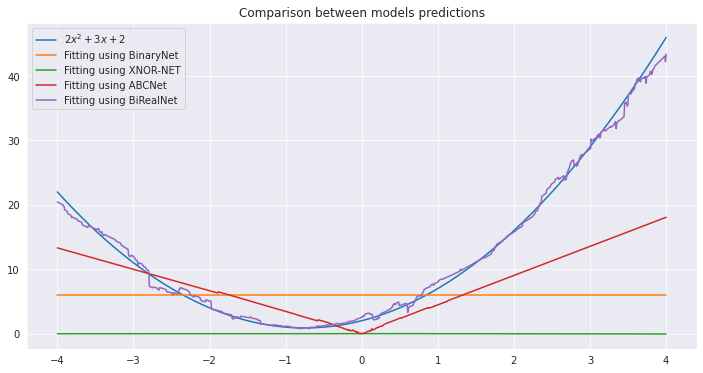

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax=plt.subplots(1,1,figsize=(12,6))
def plot_models(X,models,ax=None):
    if ax is None:
        fig,ax=plt.subplots(1,1)
    sns.lineplot(x=U,y=a*U**2+b*U+c,ax=ax,label=f"${a}x^2+{b}x+{c}$")
    for name in models:
        sns.lineplot(x=U,y=models[name].predict(U.reshape((-1,1))).reshape((-1,)),ax=ax,label=f"Fitting using {name}")

m=1000
U=np.linspace(-4,4,m)
plot_models(U,models,ax)
ax.set_title("Comparison between models predictions")
fig.savefig("local/model-performances-quadratic2.svg")

## 6. Distribution of parameters

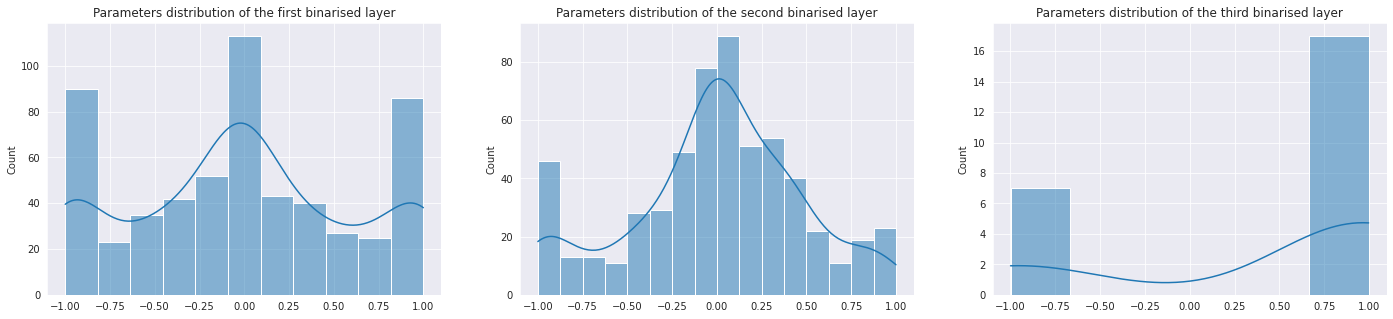

In [86]:
W=[models["XNOR-NET"].layers[2*i+2].kernel for i in range(3)]
def count_name(n):
    if n==1:
        return "first"
    if n==2:
        return "second"
    if n==3:
        return "third"


fig,axs=plt.subplots(1,3,figsize=(24,5))
for i,(w,ax) in enumerate(zip(W,axs)):
    sns.histplot(w.numpy().flatten(),ax=ax,kde=True)
    ax.set_title(f"Parameters distribution of the {count_name(i+1)} binarised layer")
fig.savefig("parameters-distribution-xnor-net.svg")

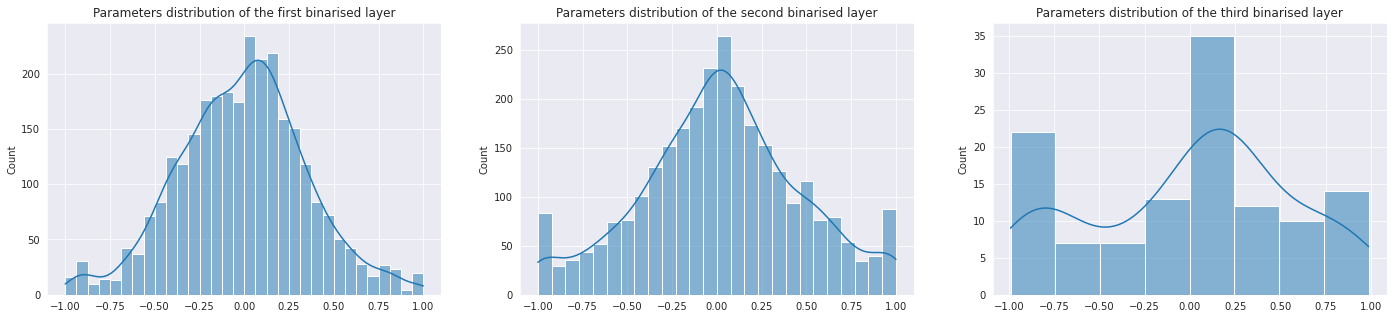

In [89]:
W=[np.array([estimator.kernel for estimator in models["ABCNet"].layers[2*i+2].estimators]) for i in range(3)]
def count_name(n):
    if n==1:
        return "first"
    if n==2:
        return "second"
    if n==3:
        return "third"


fig,axs=plt.subplots(1,3,figsize=(24,5))
for i,(w,ax) in enumerate(zip(W,axs)):
    sns.histplot(w.flatten(),ax=ax,kde=True)
    ax.set_title(f"Parameters distribution of the {count_name(i+1)} binarised layer")
fig.savefig("local/parameters-distribution-abc-net.svg")

In [34]:
    models["BiRealNet"].compile(
        tf.keras.optimizers.Adam(lr=0.01, decay=0.0001),
        loss="mean_squared_error"
    )
    models["BiRealNet"].fit(
        X_train,
        y_train,
        batch_size=128,
        epochs=29,
        validation_data=(X_test, y_test),
        shuffle=True
    )

Epoch 1/29


/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


118/118 [==============================] - 7s 13ms/step - loss: 20.8687 - val_loss: 80.5300
Epoch 2/29
118/118 [==============================] - 1s 4ms/step - loss: 7.2117 - val_loss: 12.3781
Epoch 3/29
118/118 [==============================] - 1s 4ms/step - loss: 6.4803 - val_loss: 3.4326
Epoch 4/29
118/118 [==============================] - 1s 5ms/step - loss: 7.5737 - val_loss: 15.6794
Epoch 5/29
118/118 [==============================] - 1s 5ms/step - loss: 7.6768 - val_loss: 4.1907
Epoch 6/29
118/118 [==============================] - 1s 4ms/step - loss: 6.3863 - val_loss: 3.2496
Epoch 7/29
118/118 [==============================] - 1s 4ms/step - loss: 6.4093 - val_loss: 21.1990
Epoch 8/29
118/118 [==============================] - 1s 4ms/step - loss: 4.5921 - val_loss: 6.7534
Epoch 9/29
118/118 [==============================] - 1s 5ms/step - loss: 5.5690 - val_loss: 3.4059
Epoch 10/29
118/118 [==============================] - 1s 4ms/step - loss: 4.8312 - val_loss: 6.1442
Epoc

In [30]:
bireal.layers[1].estimator.estimators

ListWrapper([<binaryflow.layers.XnorNet.ScaledQuantDense object at 0x7fee58677f40>, <binaryflow.layers.XnorNet.ScaledQuantDense object at 0x7fee586776d0>, <binaryflow.layers.XnorNet.ScaledQuantDense object at 0x7fede217b0a0>, <binaryflow.layers.XnorNet.ScaledQuantDense object at 0x7fee58677d30>, <binaryflow.layers.XnorNet.ScaledQuantDense object at 0x7fede215a850>])